In [44]:

# import system libs 
import os
import time
import shutil
import itertools

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

IMAGE_SIZE=(56,56,3)


SIZE = (56,56)

print ('modules loaded')

modules loaded


In [45]:
def prepare_for_train_test(X,Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=1)
    train_datagen = ImageDataGenerator(
        rescale=(1./255),
        rotation_range=1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

print("block executed")

block executed


In [46]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam


def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3,3),input_shape=IMAGE_SIZE, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)


    model.compile(loss='sparse_categorical_crossentropy',
                 optimizer = optimizer,
                 metrics=['accuracy'])
    print(model.summary())
    return model
print("block executed")

block executed


In [69]:
def train_model(model, X_train, Y_train, EPOCHS=15):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    history = model.fit(X_train, Y_train,
                        validation_split=0.2,
                        batch_size=32, 
                        epochs=EPOCHS, 
                        callbacks= [reduce_lr, early_stop])
    return history
print("block executed")

block executed


In [108]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=1)
    print("Test Accuracy: {:.3f}%".format(model_acc[1] * 100))  # Access accuracy

    # Generate predictions and map to class indices
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(x) for x in y_pred])

    # Classification report
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    # Display sample images with true and predicted labels
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        true_label = label_mapping[y_true[i][0] if y_true.ndim > 1 else y_true[i]]
        pred_label = label_mapping[y_pred[i]]
        plt.title(f"{true_label} | {pred_label}")
        plt.axis("off")
    plt.show() 

print("block executed")


block executed


In [ ]:
from glob import glob
import os

base_skin_dir = r'C:\Users\muham\Downloads\HAM10000'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
print(imageid_path_dict)


In [50]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

print("block executed")

block executed


In [51]:
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

print("block executed")

block executed


In [52]:
data = pd.read_csv(r'C:\Users\muham\Downloads\HAM10000\HAM10000_metadata.csv')

print("block executed")

block executed


In [53]:
data['age'].fillna(value=int(data['age'].mean()),inplace=True)
data['age'] = data['age'].astype('int32')

print("block executed")

block executed


In [54]:
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

print("block executed")

block executed


In [55]:
from PIL import Image
import numpy as np

data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize(SIZE, Image.Resampling.LANCZOS)))


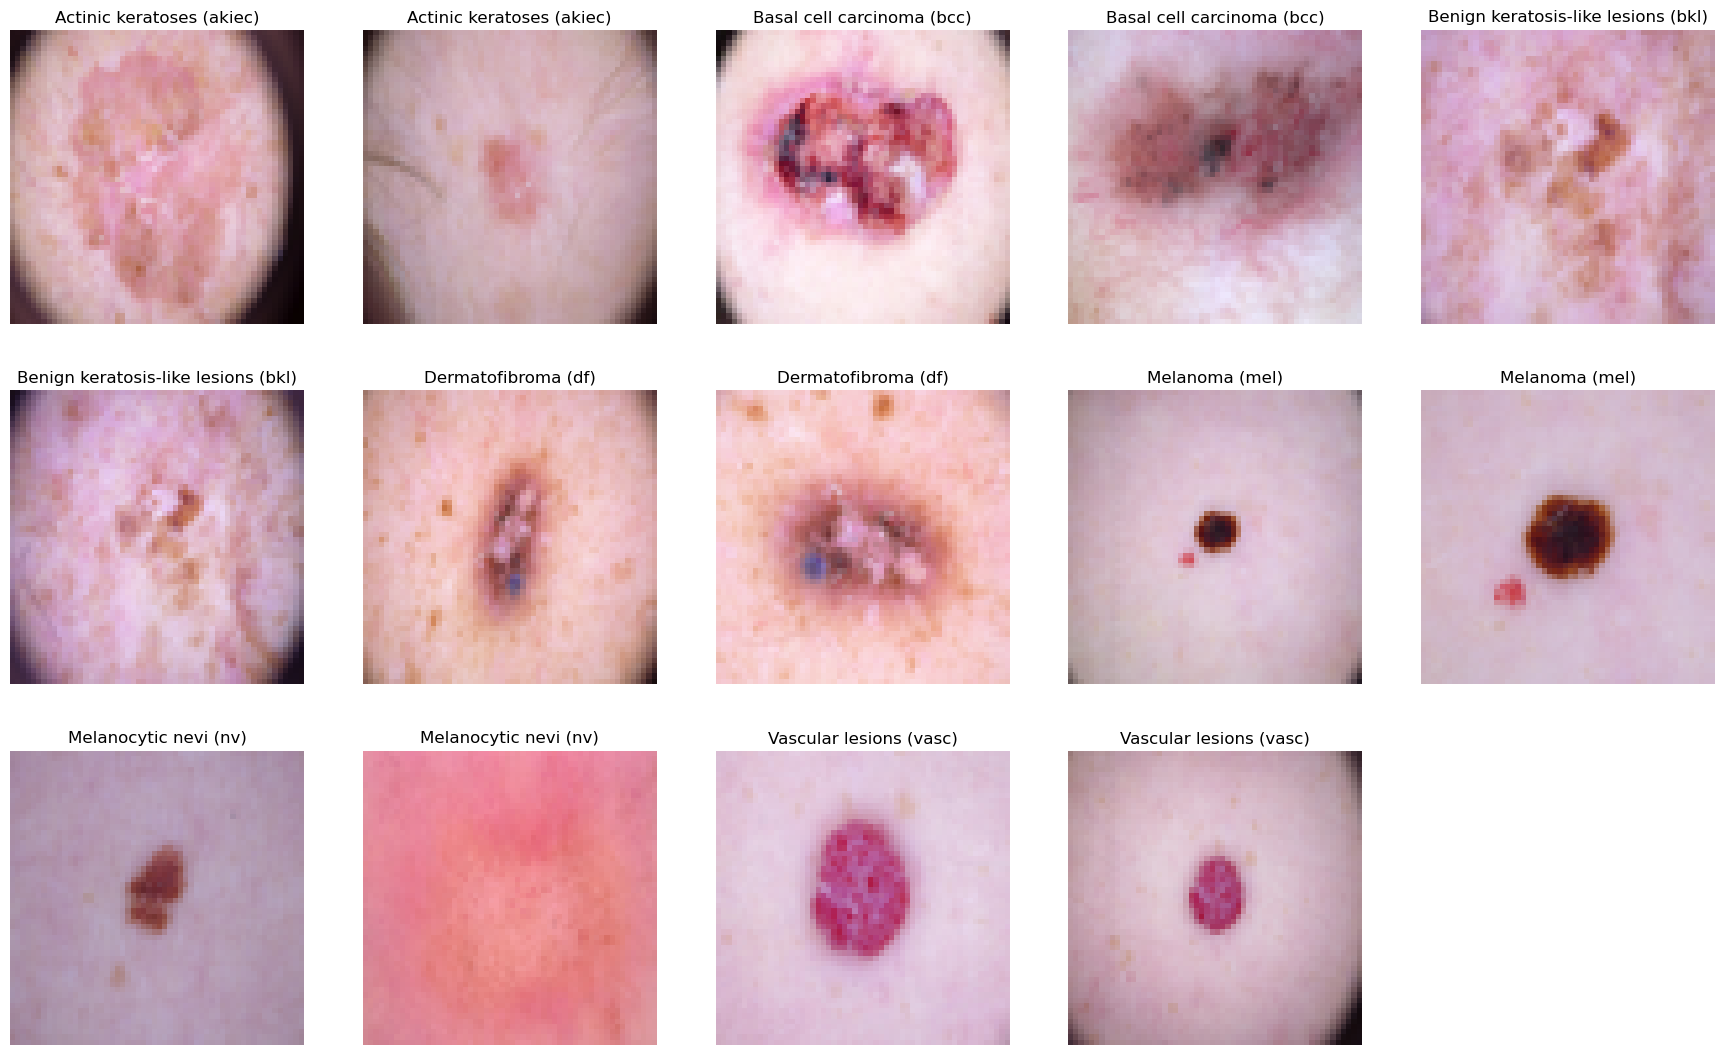

In [56]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [57]:
data['label'] = data['dx'].map(reverse_label_mapping.get)
data = data.sort_values('label')
data = data.reset_index()

In [58]:
import pandas as pd

# Assuming 'data' is your original DataFrame
counter = 0
frames = [data]

for i in [4, 4, 11, 17, 45, 52]:
    counter += 1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index) + 1)]
    
    # Use pd.concat instead of append
    df_index = pd.concat([df_index] * (i + 1), ignore_index=True)  # `i + 1` since you're including the original
    frames.append(df_index)

# Finally, concatenate all the frames together if needed
final_data = pd.concat(frames, ignore_index=True)


In [59]:
final_data = final_data.sample(frac=1).reset_index(drop=True)


In [60]:
final_data

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,1165,HAM_0005584,ISIC_0032613,df,consensus,25,female,lower extremity,Dermatofibroma (df),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[144, 131, 149], [160, 148, 170], [167, 155,...",6
1,1214,HAM_0005678,ISIC_0031023,mel,histo,60,male,chest,Melanoma (mel),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[17, 7, 15], [14, 3, 8], [21, 11, 20], [71, ...",1
2,1659,HAM_0001465,ISIC_0032699,mel,histo,65,male,ear,Melanoma (mel),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[109, 59, 51], [121, 67, 59], [130, 72, 70],...",1
3,9797,HAM_0006481,ISIC_0027753,akiec,histo,70,male,upper extremity,Actinic keratoses (akiec),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[212, 178, 199], [213, 174, 195], [194, 160,...",4
4,2703,HAM_0002224,ISIC_0029278,bcc,histo,60,male,back,Basal cell carcinoma (bcc),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[175, 135, 129], [174, 132, 129], [183, 146,...",3
...,...,...,...,...,...,...,...,...,...,...,...,...
45751,2454,HAM_0001860,ISIC_0027665,vasc,consensus,50,male,abdomen,Vascular lesions (vasc),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[239, 163, 183], [241, 164, 185], [242, 165,...",5
45752,1171,HAM_0007396,ISIC_0033554,df,consensus,35,female,lower extremity,Dermatofibroma (df),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[155, 129, 143], [158, 133, 146], [161, 137,...",6
45753,2734,HAM_0003866,ISIC_0024665,bcc,histo,65,female,abdomen,Basal cell carcinoma (bcc),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[197, 163, 158], [198, 163, 160], [200, 167,...",3
45754,2616,HAM_0000394,ISIC_0034095,bcc,histo,25,male,back,Basal cell carcinoma (bcc),C:\Users\muham\Downloads\HAM10000\HAM10000_ima...,"[[[89, 69, 82], [112, 89, 103], [132, 110, 124...",3


In [61]:
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:,-1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 56, 56, 3)
(10015, 1)


In [62]:
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:,-1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 56, 56, 3)
(45756, 1)


In [71]:
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig,Y_orig)

In [73]:
model = create_model()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,887 (901.90 KB)

 Trainable params: 230,887 (901.90 KB)

 Non-trainable params: 0 (0.00 B)

None


In [74]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [75]:
model2_history = train_model(model, X_train_aug, Y_train_aug)

Epoch 1/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.3654 - loss: 2.7504 - val_accuracy: 0.5914 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.6949 - loss: 0.7951 - val_accuracy: 0.7909 - val_loss: 0.5604 - learning_rate: 0.0010
Epoch 3/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - accuracy: 0.8071 - loss: 0.5134 - val_accuracy: 0.8701 - val_loss: 0.3493 - learning_rate: 0.0010
Epoch 4/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.8671 - loss: 0.3636 - val_accuracy: 0.8469 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 5/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.8871 - loss: 0.3043 - val_accuracy: 0.8633 - val_loss: 0.3939 - learning_rate: 0.0010
Epoch 6/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9162 - loss: 0.2294 - val_accuracy: 0.9232 - val_loss: 0.2246 - learning_rate: 0.0010
Epoch 7/15
916/916 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.9287 - l

In [85]:
model.save_weights("Skin_Cancerv3p2.weights.h5")


In [86]:
model.save('v3p2.h5')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9733 - loss: 0.1002
Test Accuracy: 97.753%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
              precision    recall  f1-score   support

          nv       1.00      0.97      0.98      1374
         mel       0.90      1.00      0.94       205
         bkl       0.95      1.00      0.97       227
         bcc       0.96      1.00      0.98        94
       akiec       1.00      1.00      1.00        55
        vasc       0.93      1.00      0.97        28
          df       0.87      1.00      0.93        20

    accuracy                           0.98      2003
   macro avg       0.94      0.99      0.97      2003
weighted avg       0.98      0.98      0.98      2003



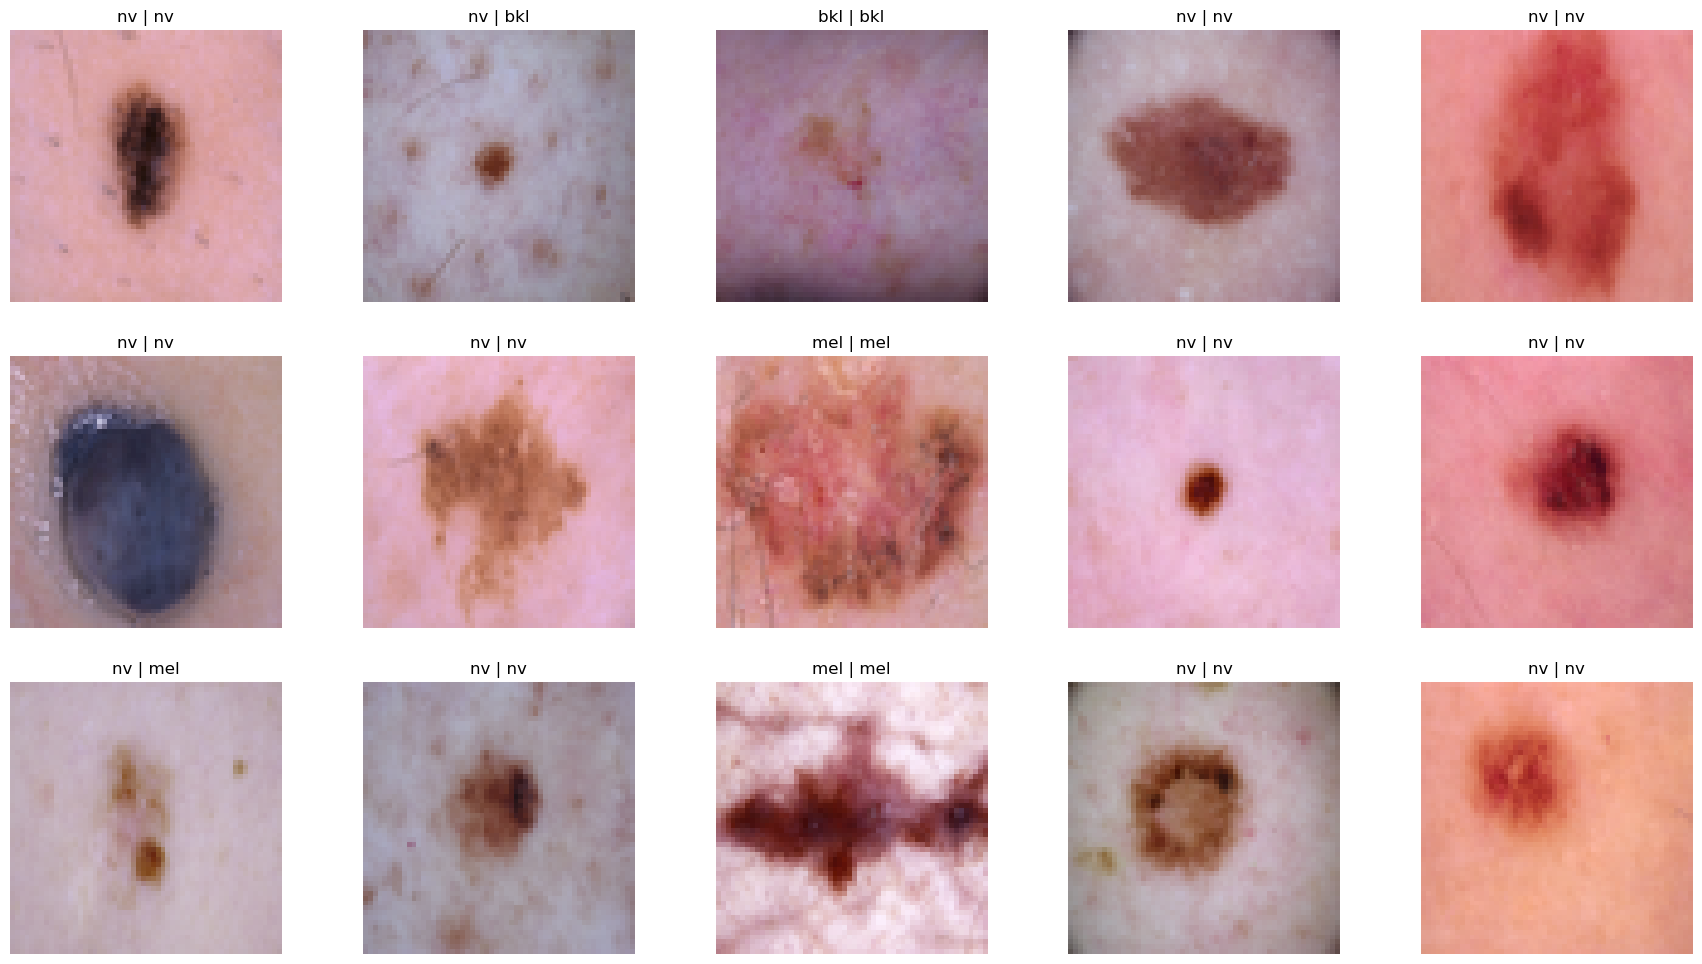

In [110]:
test_model(model, X_test_orig, Y_test_orig)
